# Exercise 01
### Lars Kühmichel
Matriculation Number: 4020471

## Task 1: Weather

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams["figure.dpi"] = 100

First, let's look at the data:

In [3]:
weather = pd.read_csv("data/dailyweather.csv")
weather

,Time,Temperature,Humidity,Pressure
0,2016,3.8,95.0,1028.3
1,2016,4.3,92.0,1016.0
2,2016,4.7,92.0,1009.1
3,2016,4.6,89.0,995.9
4,2016,5.1,89.0,998.4
...,...,...,...,...
1822,2020,1.1,72.0,1000.7
1823,2020,4.4,79.0,982.2
1824,2020,3.5,81.0,991.8
1825,2020,3.4,80.0,1004.8


We can see that the `Time` column only provides the year as an integer:

In [4]:
weather["Time"].dtype

dtype('int64')

Since we know the measurements were made daily, let's convert this to dates:

In [5]:
start = dt.date(weather["Time"][0], 1, 1)
end = start + dt.timedelta(days=len(weather) - 1)
weather["Date"] = pd.date_range(start=start, end=end)

We also want to make sure no dates were converted incorrectly. Afterwards, we can remove the `Time` column and make `Date` the index of the dataframe.

In [6]:
years = weather["Date"].dt.year

assert years.equals(weather["Time"])
del weather["Time"]
weather.set_index("Date")
print("Successfully Converted.")

Successfully Converted.


#### 1. Are any of the time series correlated with each other, and if so, how strongly?

Let's first look at the time series:

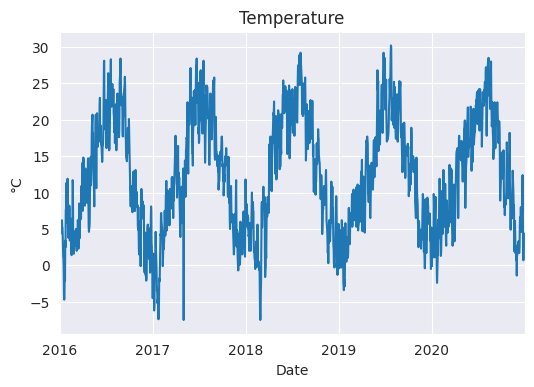

In [7]:
weather.plot("Date", "Temperature")
plt.title("Temperature")
plt.ylabel("°C")
plt.gca().get_legend().remove()

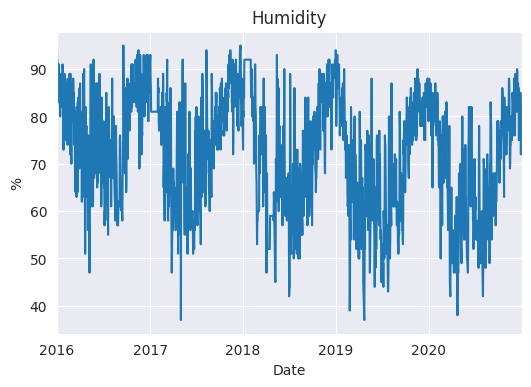

In [8]:
weather.plot("Date", "Humidity")
plt.title("Humidity")
plt.ylabel("%")
plt.gca().get_legend().remove()

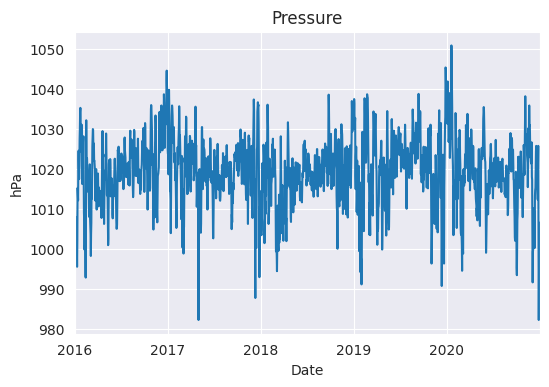

In [9]:
weather.plot("Date", "Pressure")
plt.title("Pressure")
plt.ylabel("hPa")
plt.gca().get_legend().remove()

There is a periodic pattern in every variable, most notably in temperature and humidity. As such, we would expect these to have the highest correlation. The covariance matrix confirms this. Here, we can see a strong anti-correlation between temperature and humidity, and a weak anti-correlation between humidity and pressure. Temperature and pressure are effectively not correlated.

In [10]:
weather.cov()

,Temperature,Humidity,Pressure
Temperature,60.982738,-58.023042,-1.067218
Humidity,-58.023042,151.623018,-7.608199
Pressure,-1.067218,-7.608199,72.152214


Looking at a pair-plot, we can also see this in the shape of the clusters. There is a clear trend in the cluster formed by temperature and humidity. No such trend is visible in the other clusters.

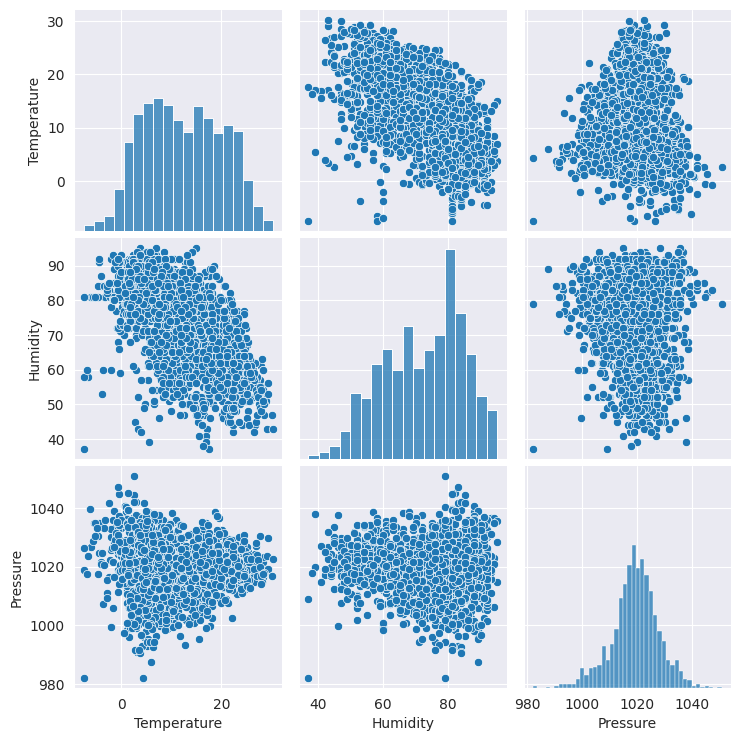

In [11]:
sns.pairplot(weather)
plt.show()

### 2. Plot the first return-map of the time series of the temperature. Do you notice any trend? What if you plot the return map for days that are a month apart?

Since the temperature is strongly auto-correlated, we see a clear trend here:

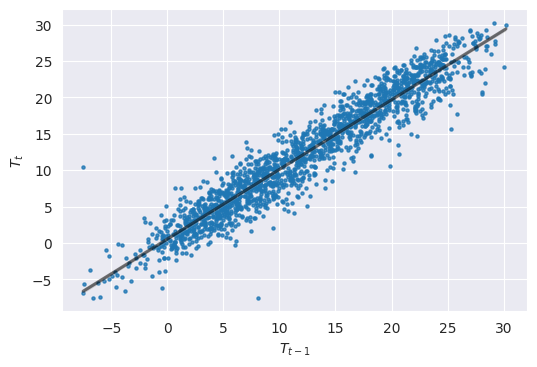

In [12]:
sns.regplot(x=weather["Temperature"][:-1], y=weather["Temperature"][1:], line_kws=dict(color="black", alpha=0.5), scatter_kws=dict(s=5))
plt.xlabel("$T_{t-1}$")
plt.ylabel("$T_t$")
plt.show()

There is more noise, but the trend is still clearly present, for days that are one month apart:

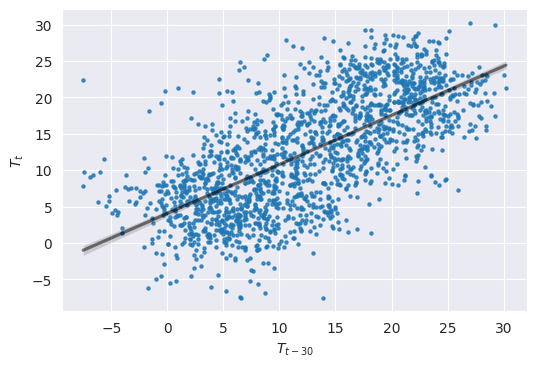

In [13]:
sns.regplot(x=weather["Temperature"][:-30], y=weather["Temperature"][30:], line_kws=dict(color="black", alpha=0.5), scatter_kws=dict(s=5))
plt.xlabel("$T_{t-30}$")
plt.ylabel("$T_t$")
plt.show()

We can explain this with the auto-correlation plot. Here, we see an auto-correlation well beyond 99% confidence (dashed lines), even for days that are one month apart.

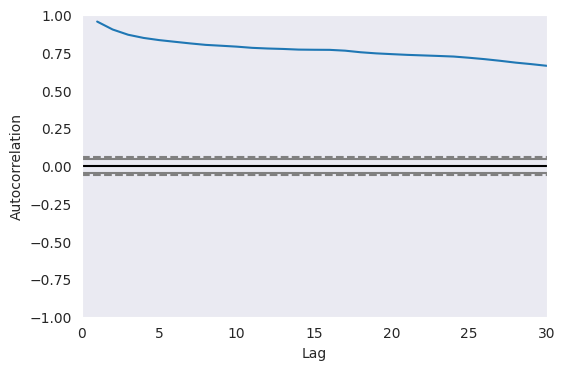

In [14]:
pd.plotting.autocorrelation_plot(weather["Temperature"])
plt.xlim(0, 30)
plt.show()

### 3. Do you notice a trend in the temperature, e.g. can you observe the climate changing over time?

A simple linear regression shows a very slightly positive trend:

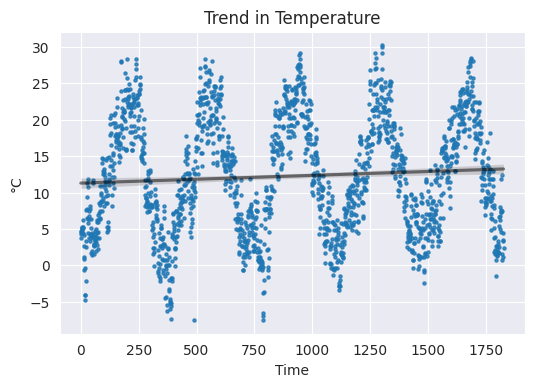

In [15]:
x = np.arange(len(weather))
y = weather["Temperature"].to_numpy()
sns.regplot(x=x, y=y, line_kws=dict(color="black", alpha=0.5), scatter_kws=dict(s=5))
plt.xlabel("Time")
plt.ylabel("°C")
plt.title("Trend in Temperature")
plt.show()

The slope coefficient is very small, it is barely significantly different from zero. Here is the 95% confidence interval:

In [16]:
import statsmodels.api as sm

x = np.arange(len(weather)).reshape(-1, 1)
x = sm.add_constant(x)

y = weather["Temperature"].to_numpy()

model = sm.OLS(y, x)
res = model.fit()

conf_int = pd.DataFrame(data=res.conf_int(), index=["Intercept", "Slope"], columns=["0.025", "0.975"])

conf_int

,0.025,0.975
Intercept,10.581874,12.011247
Slope,0.000386,0.001742


We can also look at a polar plot, such that seasonal changes occur at the same position in the plot:

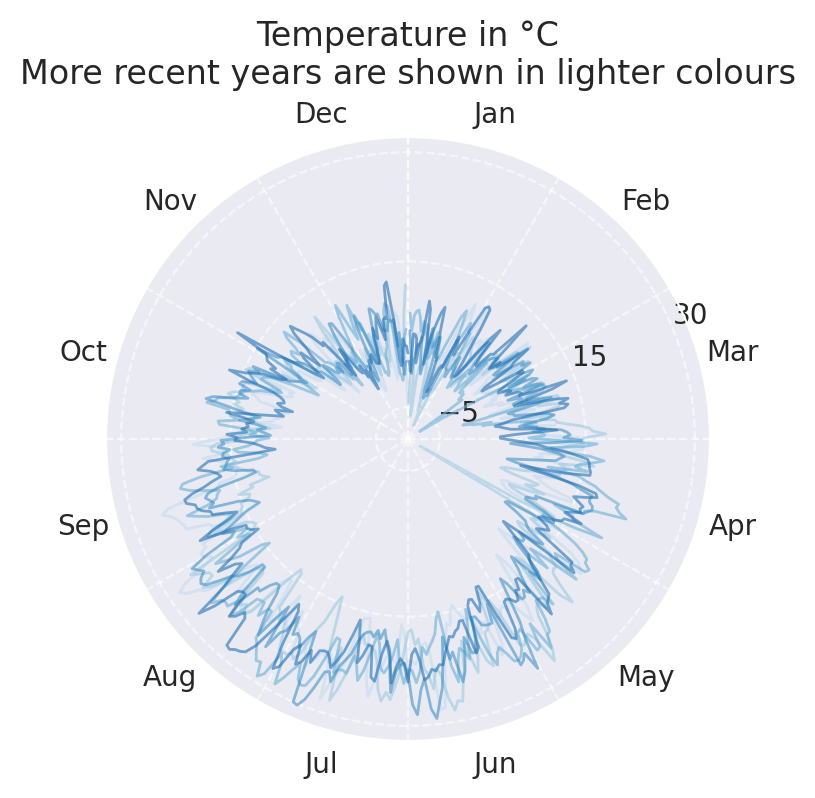

In [17]:
import matplotlib.ticker as ticker
from matplotlib.cm import get_cmap

# find the day of the year for each measurement
dti = pd.DatetimeIndex(weather["Date"])
doy = dti.day_of_year

# convert into an angle, starting at the top, looping clockwise
phi = 90 - 360 * doy / doy.max()
phi = np.deg2rad(phi)

temp = weather["Temperature"].to_numpy()


# make it a polar plot
fig = plt.figure(dpi=200)
ax = fig.add_subplot(projection="polar")

# line plot does not support colormaps, so plot each year with a different color
years = pd.unique(dti.year)
fractions = 0.25 + 0.5 * (years - years.min()) / (years.max() - years.min())
cmap = get_cmap("Blues")
colors = cmap(fractions)
for year, color in zip(years, colors):
    idx = dti.year == year
    ax.plot(phi[idx], temp[idx], lw=1.0, alpha=0.6, color=color)
ax.grid(which="major", ls="--", alpha=0.6)


# separating grid line ticks with no labels
ticks = 90 - 360 * np.linspace(0, 1, 13)
ticks = ticks % 360
ticks = np.deg2rad(ticks)
ax.set_xticks(ticks, labels="")

# centered label ticks
ticks = np.rad2deg(ticks)
ticks = ticks - 360 / 24
ticks = ticks % 360
ticks = np.deg2rad(ticks)
labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# use fixed formatting for both
ax.xaxis.set_minor_locator(ticker.FixedLocator(ticks))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.set_yticks([-5, 15, 30])

ax.set_title("Temperature in °C\nMore recent years are shown in lighter colours")

plt.show()

This plot also shows no clear trend, due to the low SNR. It is likely that more measurements from different areas would be needed to eliminate local climate influences.

## Task 2: Detrending and autocorrelation

### 1. By using linear regression, remove the trend from the datasets.

Again, first load the data

In [18]:
investment = pd.read_excel("data/investment.xls")
investment

,investment
0,0.001737
1,0.001683
2,0.001739
3,0.001866
4,0.001912
...,...
163,0.003584
164,0.003603
165,0.003686
166,0.003715


Check out the trend:

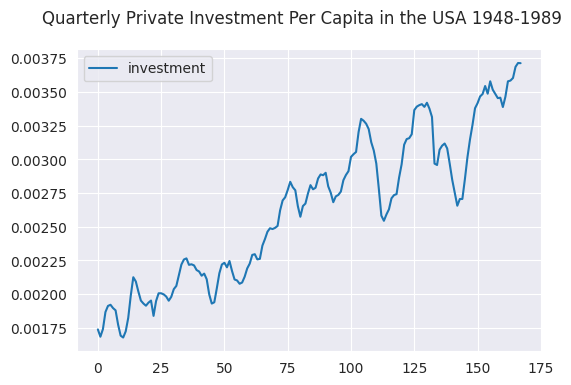

In [19]:
investment.plot()
plt.gcf().suptitle("Quarterly Private Investment Per Capita in the USA 1948-1989")
plt.show()

`scipy` provides easy detrending:

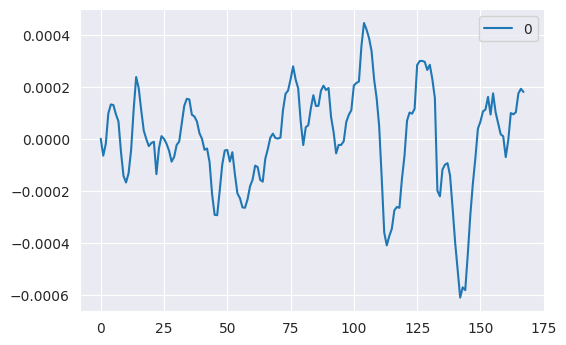

In [20]:
from scipy import signal

investment = pd.DataFrame(signal.detrend(investment, axis=0))

investment.plot()
plt.show()

### 2. Examine (loosely) whether the time series with the linear trend removed is stationary. Is the time series (of the original series before regression) of first differences stationary? How about the time series of second-order differences?

Reminder: weak-sense stationarity requires

1. Constant mean: $\mathbb{E} [x_t] = \mu_t = \operatorname{const.} \quad \forall t$
2. Constant autocovariance: $\operatorname{acov}[x_t, x_{t + \Delta t}] = \operatorname{acov} [\Delta t] \quad \forall t, \Delta t$

Since we detrended the data, we can assume the mean is constant. At first glance, the autocovariance does not look constant, since the signal has more variance in later measurements than in earlier ones. However, examining it more closely yields that the autocovariance mostly oscillates around zero. It is therefore not unreasonable to assume stationarity:

In [21]:
def acov(x, dt):
    """ Compute the auto-covariance over a time-series x for a fixed dt """
    t1 = np.arange(x.shape[1] - dt)
    t2 = t1 + dt

    x1 = x[:, t1]
    x2 = x[:, t2]
    mu1 = np.mean(x1)
    mu2 = np.mean(x2)

    return np.mean(x1 * x2 - mu1 * mu2, axis=0)

In [22]:
ts = investment.to_numpy().T
ts.shape

(1, 168)

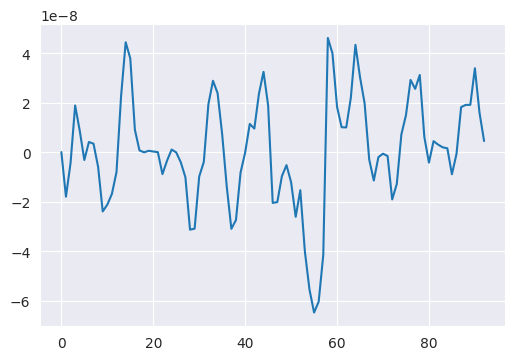

In [23]:
plt.plot(acov(ts, dt=75))
plt.show()

The same applies to the time series of first differences:

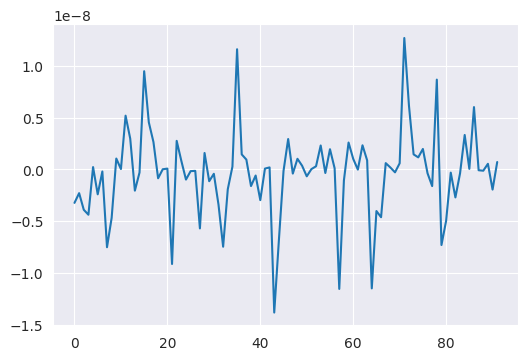

In [24]:
first_differences = np.diff(ts)
plt.plot(acov(first_differences, dt=75))
plt.show()

And also the second-order differences:

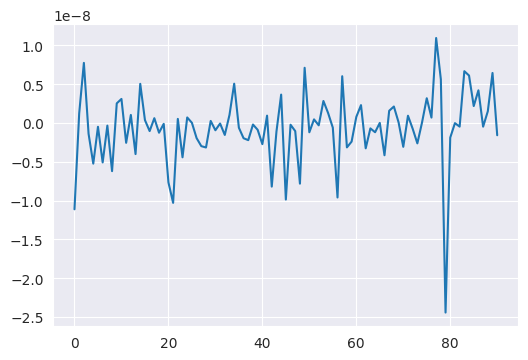

In [25]:
second_differences = np.diff(ts, n=2)
plt.plot(acov(second_differences, dt=75))
plt.show()

### 3. Compute the autocorrelation function of the detrended time series. Can you find periodic business cycles (corresponding to peaks in the autocorrelation function)?

My implementation for the autocorrelation differs from the pandas implementation: correlations with greater lag are scaled down in the library implementation. Neither plot shows a clear peak, however, so no business cycle can be extracted here.

In [26]:
def acorr(x, dt):
    """ Compute the auto-correlation over a time-series x for a fixed dt """
    t1 = np.arange(x.shape[1] - dt)
    t2 = t1 + dt

    x1 = x[:, t1]
    x2 = x[:, t2]
    sig1 = np.std(x1)
    sig2 = np.std(x2)

    return acov(x, dt) / (sig1 * sig2)

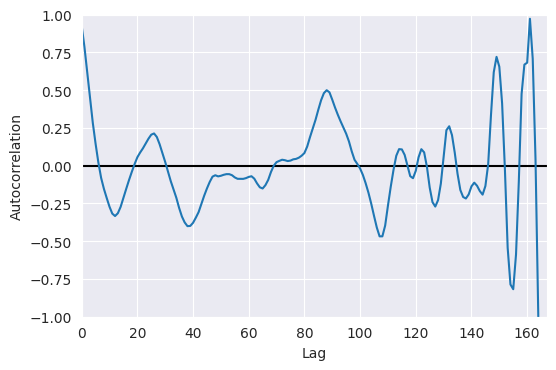

In [27]:
acorrs = np.array([np.mean(acorr(ts, dt=dt)) for dt in range(1, ts.shape[1] - 2)])

plt.ylim(-1, 1)
plt.xlim(0, ts.shape[1] - 1)
plt.axhline(y=0, color="black")
plt.plot(acorrs)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

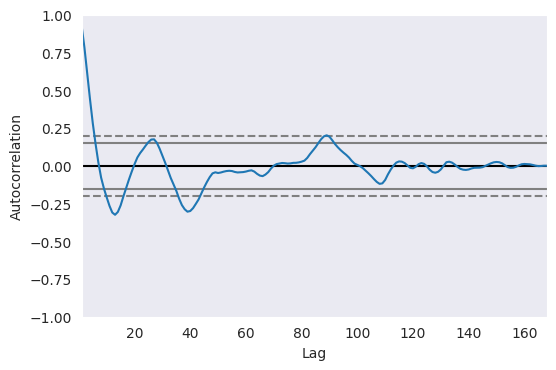

In [28]:
pd.plotting.autocorrelation_plot(investment)
plt.show()

## Task 3: AR models

### 1. Create your own AR time series with the given parameters.

The naive for-loop implementation is fast enough, so we will use that:

In [29]:
T = 200
p = 4
a = [0, -0.8, 0, 0, 0.4]

x = np.zeros(T)
for t in range(T):
    x[t] = a[0] + sum([a[i] * x[t - i] for i in range(1, p)]) + np.random.normal()

### 2. Plot the time series in time as well as the first return-map. What do you notice?

The plot for the time series shows no obvious trends, or cycles.

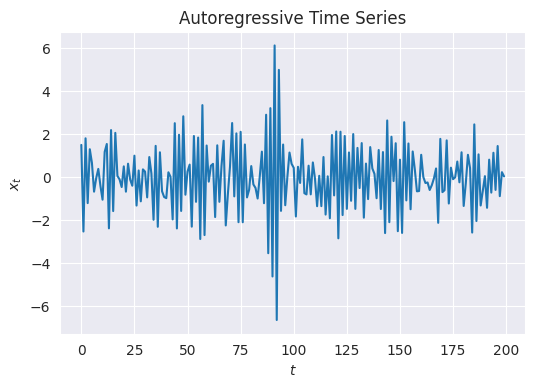

In [30]:
plt.plot(x)
plt.xlabel("$t$")
plt.ylabel("$x_t$")
plt.title("Autoregressive Time Series")
plt.show()

In contrast, the return map shows a clear trend.

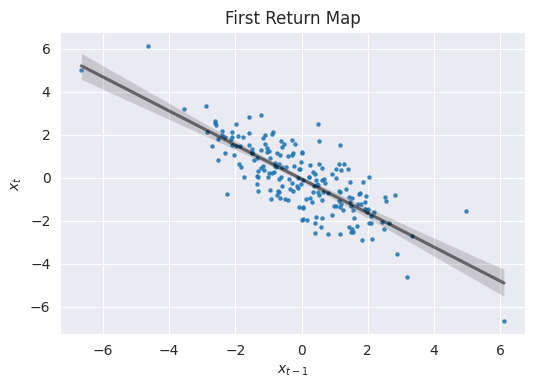

In [31]:
sns.regplot(x=x[:-1], y=x[1:], line_kws=dict(color="black", alpha=0.5), scatter_kws=dict(s=5))
plt.xlabel("$x_{t-1}$")
plt.ylabel("$x_t$")
plt.title("First Return Map")
plt.show()